In [1]:
import pandas as pd
import numpy as np
import pyreadr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

from utils import preprocess_data, plot_confusion_matrix

In [2]:
path = "./gss_16.rda"

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

# Phân loại tập dữ liệu thời gian sử dụng email khác null sử dụng mạng neuron kết nối đầy đủ

### Xử lý dữ liệu

In [5]:
x, y, features_list, value_to_index = preprocess_data(df=df, remove_email_null=True, use_text_categorical=False, one_hot_encode=True)

### Biến y thành dữ liệu kiểu số nguyên

In [6]:
y_encoded = np.vectorize(lambda x: value_to_index['wrkstat'][x])(y)

In [7]:
y_encoded
y = y_encoded

### Phân chia dữ liệu

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Class cho dataset của Pytorch

In [9]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

### Mô hình mạng neuron một lớp ẩn

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

### Hàm huấn luyện và in ra kết quả huấn luyện (Precision, Recall, F1-Score và ma trận nhầm lẫn)

In [11]:
def train_and_get_performance(X_train, X_test, y_train, y_test, value_to_index=value_to_index, hidden_size=64, lr=1e-4, num_epochs=10, batch_size=64, num_classes=8):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_size = X_train.shape[1]
    model = MLP(input_size, hidden_size, num_classes)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        model.eval()
        with torch.no_grad():
            y_true = []
            y_pred = []
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(batch_y.tolist())
                y_pred.extend(predicted.tolist())
    
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(batch_y.tolist())
            y_pred.extend(predicted.tolist())    
        # Generate classification report
    target_names = [k for k, v in value_to_index['wrkstat'].items()]
    print(target_names)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
    
    print("Classification Report:")
    print(report)
    plot_confusion_matrix(y_true, y_pred, target_names)

### Huấn luyện mô hình

Epoch [1/10], Loss: 2.0930
Epoch [2/10], Loss: 2.0851
Epoch [3/10], Loss: 2.0640
Epoch [4/10], Loss: 2.0526
Epoch [5/10], Loss: 2.0844
Epoch [6/10], Loss: 1.9803
Epoch [7/10], Loss: 2.0044
Epoch [8/10], Loss: 2.0272
Epoch [9/10], Loss: 1.9871
Epoch [10/10], Loss: 1.9834
['Keeping house', 'Other', 'Retired', 'School', 'Temp not working', 'Unempl, laid off', 'Working fulltime', 'Working parttime']
Classification Report:
                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        58
           Other       0.00      0.00      0.00         8
         Retired       0.17      0.08      0.11       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.54      0.93      0.68       351
Working parttime       0.00      0.00      0.00        80

        accuracy                           0.51       

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

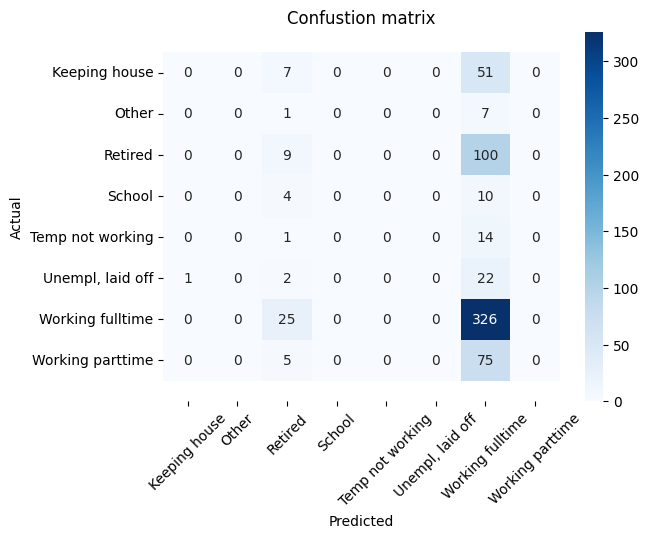

In [12]:
train_and_get_performance(X_train, X_test, y_train, y_test)

# Phân loại tập dữ liệu thời gian sử dụng email bằng null sử dụng mạng neuron kết nối đầy đủ

Xử lý dữ liệu

In [13]:
x, y, features_list, value_to_index = preprocess_data(df=df, remove_email_null=False, use_text_categorical=False, one_hot_encode=True)

In [14]:
y

array(['Retired', 'Working parttime', 'Working parttime', ...,
       'Working parttime', 'Retired', 'Retired'], dtype=object)

### Mã hóa y thành kiểu số nguyên

In [15]:
y_encoded = np.vectorize(lambda x: value_to_index['wrkstat'][x])(y)

In [16]:
y_encoded

array([2, 7, 7, ..., 7, 2, 2])

In [17]:
y_encoded
y = y_encoded

### Phân chia tập dữ liệu

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình và in ra kết quả

Epoch [1/20], Loss: 2.0304
Epoch [2/20], Loss: 2.0407
Epoch [3/20], Loss: 2.0392
Epoch [4/20], Loss: 2.0551
Epoch [5/20], Loss: 2.0297
Epoch [6/20], Loss: 1.9836
Epoch [7/20], Loss: 2.0187
Epoch [8/20], Loss: 1.9544
Epoch [9/20], Loss: 1.9615
Epoch [10/20], Loss: 1.9629
Epoch [11/20], Loss: 1.8885
Epoch [12/20], Loss: 1.9111
Epoch [13/20], Loss: 1.8881
Epoch [14/20], Loss: 1.8398
Epoch [15/20], Loss: 1.8554
Epoch [16/20], Loss: 1.9499
Epoch [17/20], Loss: 1.8995
Epoch [18/20], Loss: 1.8178
Epoch [19/20], Loss: 1.8100
Epoch [20/20], Loss: 1.9120
['Keeping house', 'Other', 'Retired', 'School', 'Temp not working', 'Unempl, laid off', 'Working fulltime', 'Working parttime']
Classification Report:
                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        55
           Other       0.00      0.00      0.00        23
         Retired       0.39      0.49      0.43       113
          School       0.00      0.00      0.00        13
Temp no

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

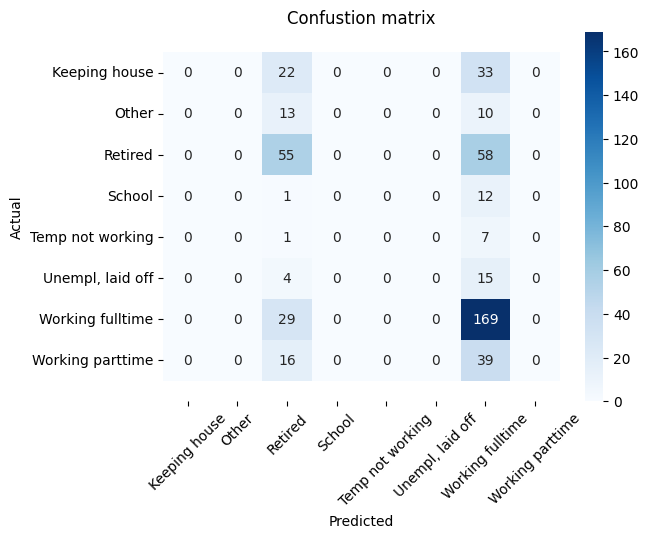

In [19]:
train_and_get_performance(X_train, X_test, y_train, y_test, num_epochs=20, lr=1e-4)